# 📧 스팸 필터링: 나이브 베이즈 기반 LSTM 필터링 모델

1.   데이터 시각화

2.   데이터 전처리

    *   데이터 클리닝
    *   Countvectorizer, TF-IDF
    *   Tokenizer

3.   ML 모델 및 성능 평가
    *   MultinomialNB
    *   Logistic Regression
    *   LSTM

4.   스팸 필터링 모델
    *   모델 선정: 필터링 기반 나이브 베이즈 및 LSTM
    *   테스트 예측








In [1]:
!pip install contractions

     |████████████████████████████████| 284 kB 4.2 MB/s 
     |████████████████████████████████| 321 kB 38.6 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85439 sha256=02e913c404281f9a75ce2a3b32284284661c1f1ba29f7a1d7dc0879fa9953d40
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import contractions
import re
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,  plot_confusion_matrix

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

import keras
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# train_set = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/train.csv')
# test_set = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/test.csv')
# Colab용 파일 경로

train_set = pd.read_csv('./data/train.csv')
test_set = pd.read_csv('./data/test.csv'')
# 제출용 파일 경로

In [4]:
train_set.info()
# train_set에 null 있는지 확인한다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3620 entries, 0 to 3619
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3620 non-null   int64 
 1   label   3620 non-null   int64 
 2   mail    3620 non-null   object
dtypes: int64(2), object(1)
memory usage: 85.0+ KB


In [5]:
train_set = train_set.drop_duplicates(['mail'])
train_set.info()
# (3620-3528=92)개 중복 데이터 삭제

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3528 entries, 0 to 3619
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3528 non-null   int64 
 1   label   3528 non-null   int64 
 2   mail    3528 non-null   object
dtypes: int64(2), object(1)
memory usage: 110.2+ KB


# 1. 데이터 시각화
주어진 데이터를 단어 빈도에 따라 시각화한다.

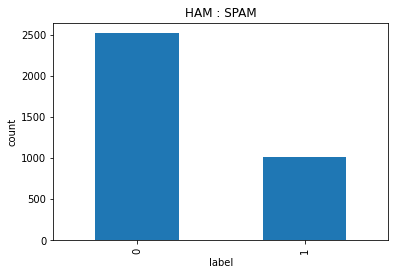

In [6]:
train_set['label'].value_counts().plot(kind = 'bar', title="HAM : SPAM", ylabel='count', xlabel='label')

주어진 데이터 중 스팸이 더 적다(2500개 대 1000개 정도).

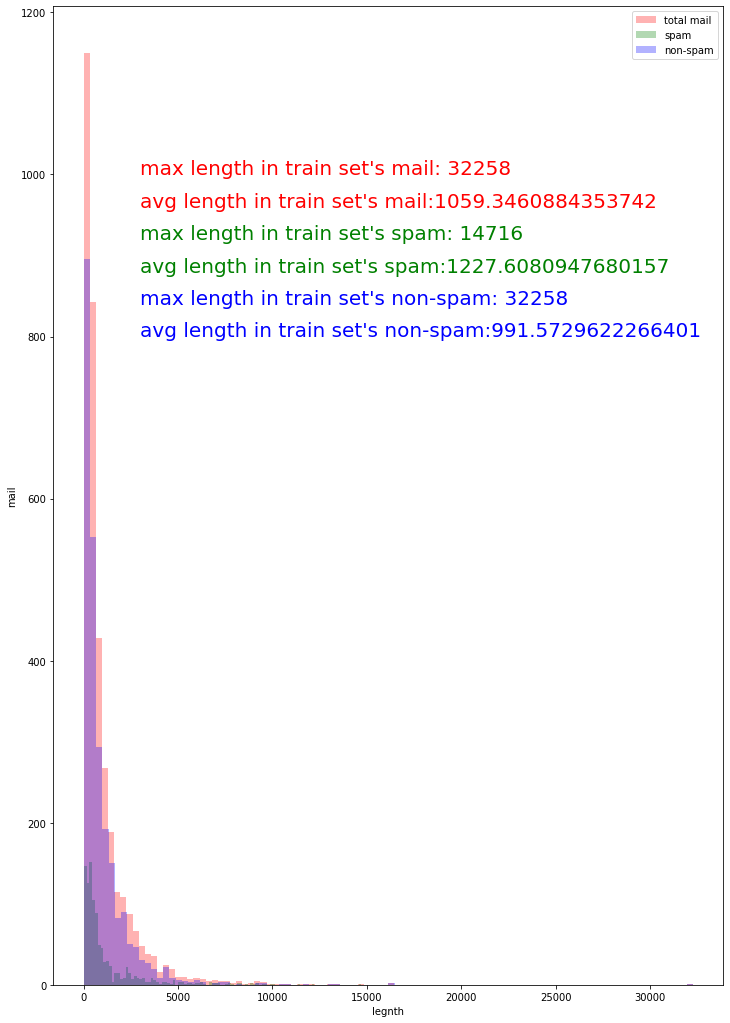

In [65]:
train_set['length'] = train_set['mail'].apply(len)

plt.figure(figsize=(12,18))
plt.hist(train_set['length'], bins = 100, alpha=0.3, color = 'r')
plt.hist(train_set[train_set['label']==1]['length'], bins = 100, alpha=0.3, color = 'g')
plt.hist(train_set[train_set['label']==0]['length'], bins = 100, alpha=0.3, color = 'b')
plt.text(3000, 1000, "max length in train set's mail: " + str(max(train_set['length'])), fontsize=20, color='r')
plt.text(3000, 960, "avg length in train set's mail:" + str(sum(train_set['length'])/len(train_set['length'])), fontsize=20, color='r')
plt.text(3000, 920, "max length in train set's spam: " + str(max(train_set[train_set['label']==1]['length'])), fontsize=20, color='g')
plt.text(3000, 880, "avg length in train set's spam:" + str(sum(train_set[train_set['label']==1]['length']) / len(train_set[train_set['label']==1]['length'])), fontsize=20, color='g')
plt.text(3000, 840, "max length in train set's non-spam: " + str(max(train_set[train_set['label']==0]['length'])), fontsize=20, color='b')
plt.text(3000, 800, "avg length in train set's non-spam:"+ str(sum(train_set[train_set['label']==0]['length']) / len(train_set[train_set['label']==0]['length'])), fontsize=20, color='b')


plt.xlabel('legnth')
plt.ylabel('mail')
plt.legend(['total mail', 'spam', 'non-spam'])
plt.show()

In [66]:
def word_count_plot(mail, title):     
     word_counter = collections.Counter([word for sentence in mail for word in sentence.split()])
     most_count = word_counter.most_common(50)
     most_count = pd.DataFrame(most_count, columns=["Word", "Frequent"]).sort_values(by="Frequent")
     most_count.plot.barh(title=title, x = "Word", y = "Frequent", figsize=(6, 12))
     # 메일 중 가장 흔한 단어 상위 50개 시각화

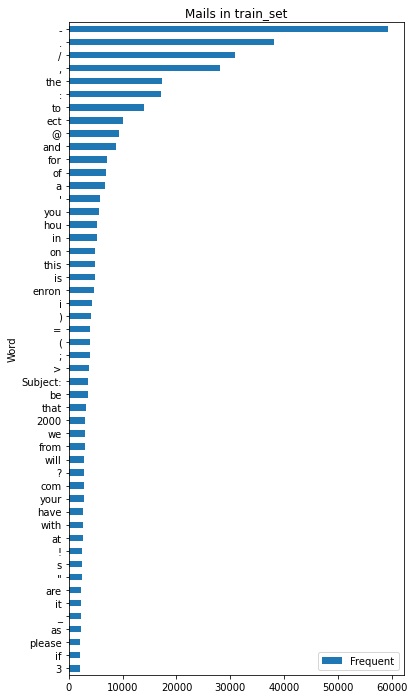

In [67]:
word_count_plot(train_set['mail'], "Mails in train_set")

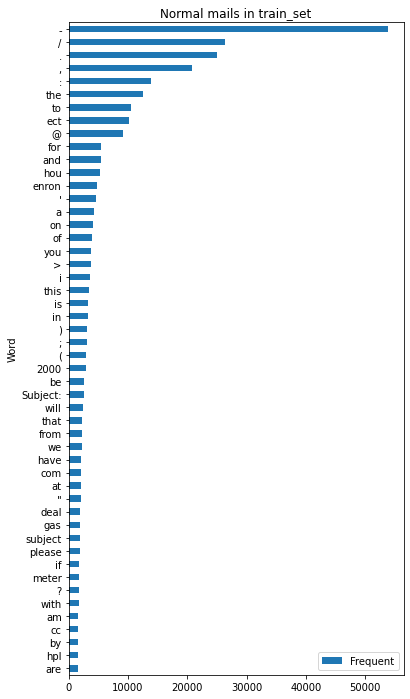

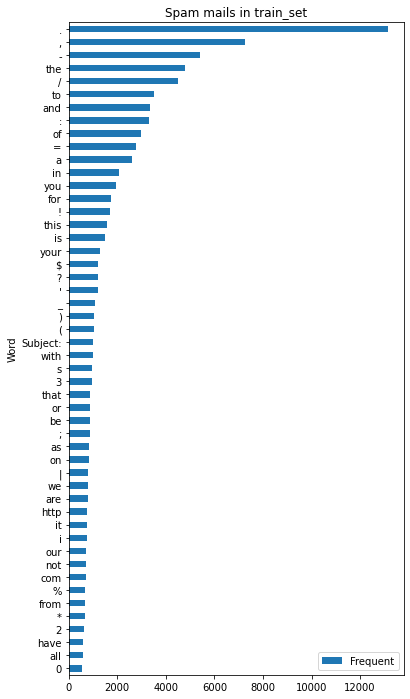

In [68]:
word_count_plot(train_set[train_set['label']==0].mail, "Normal mails in train_set")
word_count_plot(train_set[train_set['label']==1].mail, "Spam mails in train_set")

전반적으로 의미를 알기 어렵거나('.', ','), 불용어(a, to), 특수문자(@, $)가 존재한다. 

데이터 클리닝 이후에는 어떤지 다시 확인해보자.

ML 및 DL 학습에 사용할 데이터를 가공하는 조건을 다양하게 설정해 확인해본다.

# 2. 데이터 전처리
> 데이터 클리닝

단어를 각 기준(정규화, 표제어, 불용어 등)에 따라 가공한다. 다양한 가공 조건 중 특히 네 가지를 뽑아 이후 모델에 적용한다.

In [69]:
lem = WordNetLemmatizer()
def preprocess(mail, contract, lower, noops, stop, lemma):  
      text = mail
      if contract: text = contractions.fix(mail) # 약어 정규화 (i'm -> i am)
      if lower: text = text.lower() # 소문자화
      if noops: text = re.sub("[^a-z ]", "", text) # 특수문자, 숫자 제거
      text = text.split()
      if stop: text = [word for word in text if not word in set(stopwords.words('english'))] # 불용어 제거
      if lemma: text = [lem.lemmatize(word) for word in text] # 표제어
      text = " ".join(text)
      return text

In [70]:
train_input1 = train_set['mail'].apply(lambda x: preprocess(x, contract=True, lower=True, noops=True, stop=True, lemma=True))
test_input1 = test_set['mail'].apply(lambda x: preprocess(x, contract=True, lower=True, noops=True, stop=True, lemma=True))

1번: 주어진 조건을 모두 사용하였다.

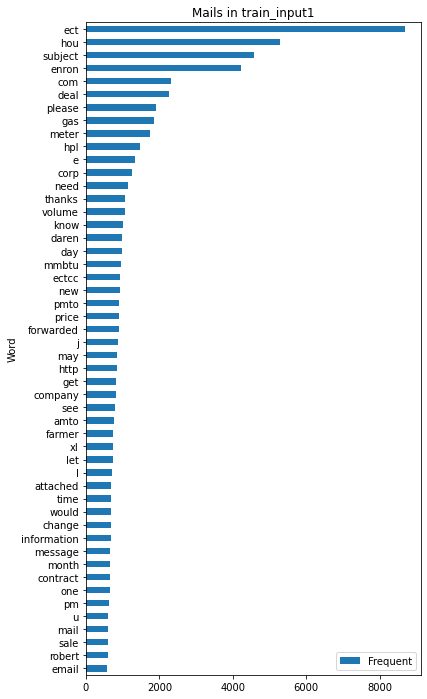

In [73]:
word_count_plot(train_input1, "Mails in train_input1")

In [74]:
train_input2 = train_set['mail'].apply(lambda x: preprocess(x, contract=True, lower=False, noops=True, stop=True, lemma=True))
test_input2 = test_set['mail'].apply(lambda x: preprocess(x, contract=True, lower=False, noops=True, stop=True, lemma=True))

2번: 소문자화만 하지 않았다.

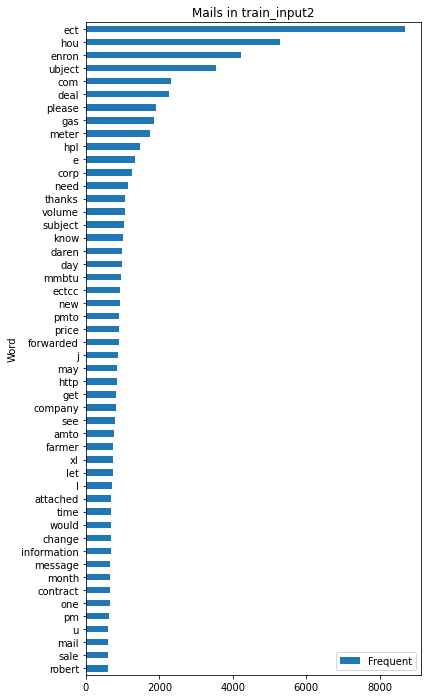

In [75]:
word_count_plot(train_input2, "Mails in train_input2")

In [76]:
train_input3 = train_set['mail'].apply(lambda x: preprocess(x, contract=True, lower=True, noops=False, stop=True, lemma=True))
test_input3 = test_set['mail'].apply(lambda x: preprocess(x, contract=True, lower=True, noops=False, stop=True, lemma=True))

3번: 특수문자 및 숫자를 제거하지 않았다.


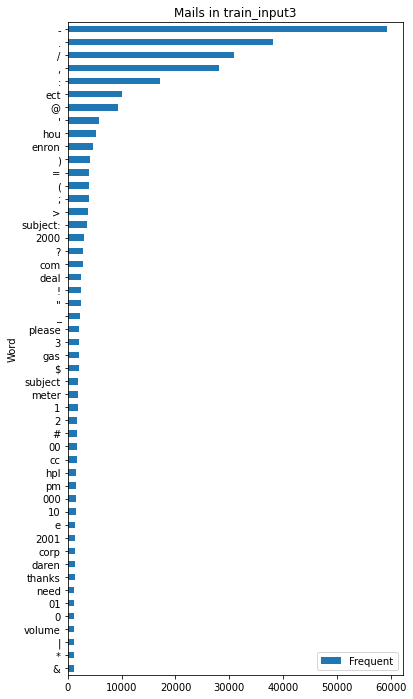

In [77]:
word_count_plot(train_input3, "Mails in train_input3")

In [78]:
train_input4 = train_set['mail'].apply(lambda x: preprocess(x, contract=True, lower=True, noops=True, stop=False, lemma=False))
test_input4 = test_set['mail'].apply(lambda x: preprocess(x, contract=True, lower=True, noops=True, stop=False, lemma=False))

4번: 불용어와 표제어를 제거하지 않았다.

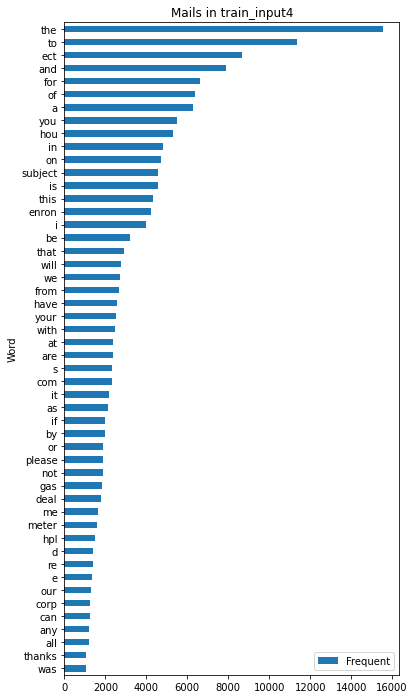

In [79]:
word_count_plot(train_input4, "Mails in train_input4")



> Countvectorizer, TF-IDF

가공한 텍스트를 벡터화한다. 단어 빈도에 따라 BoW(Bag of Words)를 만드는 Countvectorizer와 가중치를 둔 TF-IDF를 사용한다. 

벡터화한 데이터는 이후 나이브 베이즈(multinomialNB), 로지스틱 회귀 분류 기법에 사용한다.

In [80]:
def vectorizer(train_input, val_input, test_input):
    vectorizer = CountVectorizer()
    train_input = vectorizer.fit_transform(train_input)
    val_input = vectorizer.transform(val_input)
    test_input = vectorizer.transform(test_input)
    return (train_input, val_input, test_input)

In [81]:
def tfidv(train_input, val_input, test_input):
    tfidv = TfidfVectorizer()
    train_input = tfidv.fit_transform(train_input)
    val_input = tfidv.transform(val_input)
    test_input = tfidv.transform(test_input)
    return (train_input, val_input, test_input)

> Tokenizer

가공한 데이터를 토큰화(텍스트→시퀸스) 및 패딩한다.
벡터화한 데이터는 이후 LSTM 모델에 사용한다.

In [82]:
def tokenizer(train_input, val_input, test_input, max_len):
    tokenizer = Tokenizer(num_words= max_len)
    tokenizer.fit_on_texts(train_input)
    train_sequence = tokenizer.texts_to_sequences(train_input)
    val_sequence = tokenizer.texts_to_sequences(val_input)
    test_sequence = tokenizer.texts_to_sequences(test_input)
    max_words = len(tokenizer.word_index) + 1
    return (train_sequence, val_sequence, test_sequence, max_words)

In [83]:
def padding(train_sequence, val_sequence, test_sequence, max_length_sequence):
    train_padded = pad_sequences(train_sequence, maxlen=max_length_sequence)
    val_padded = pad_sequences(val_sequence, maxlen=max_length_sequence)
    test_padded = pad_sequences(test_sequence, maxlen=max_length_sequence)
    return (train_padded, val_padded, test_padded)

In [84]:
train_target = train_set['label']

train_input1, val_input1, train_target1, val_target1 = train_test_split(train_input1, train_target, test_size=0.2, stratify=train_target)
train_input2, val_input2, train_target2, val_target2 = train_test_split(train_input2, train_target, test_size=0.2, stratify=train_target)
train_input3, val_input3, train_target3, val_target3 = train_test_split(train_input3, train_target, test_size=0.2, stratify=train_target)
train_input4, val_input4, train_target4, val_target4 = train_test_split(train_input4, train_target, test_size=0.2, stratify=train_target)

데이터 전처리를 통해 가공한 데이터를 train_input, val_input으로 분류한다. 

원본 데이터 내 스팸 비율이 더 적으므로, stratify를 통해 label이 치우쳐지지 않도록 한다.

In [85]:
train_vect1, val_vect1, test_vect1 = vectorizer(train_input1, val_input1, test_input1)
train_vect2, val_vect2, test_vect2 = vectorizer(train_input2, val_input2, test_input2)
train_vect3, val_vect3, test_vect3 = vectorizer(train_input3, val_input3, test_input3)
train_vect4, val_vect4, test_vect4 = vectorizer(train_input4, val_input4, test_input4)


train_tf1, val_tf1, test_tf1 = tfidv(train_input1, val_input1, test_input1)
train_tf2, val_tf2, test_tf2 = tfidv(train_input2, val_input2, test_input2)
train_tf3, val_tf3, test_tf3 = tfidv(train_input3, val_input3, test_input3)
train_tf4, val_tf4, test_tf4 = tfidv(train_input4, val_input4, test_input4)

train_input, val_input, test_input을 각각 벡터화한다.

In [175]:
max_len = 1000
train_sequence1, val_sequence1, test_sequence1, word_index1 = tokenizer(train_input1, val_input1, test_input1, max_len)
max_length_sequence1 = max([len(i) for i in train_sequence1])
train_pad1, val_pad1, test_pad1 = padding(train_sequence1, val_sequence1, test_sequence1, max_length_sequence1)

train_sequence2, val_sequence2, test_sequence2, word_index2 = tokenizer(train_input2, val_input2, test_input2, max_len)
max_length_sequence2 = max([len(i) for i in train_sequence2])
train_pad2, val_pad2, test_pad2 = padding(train_sequence2, val_sequence2, test_sequence2, max_length_sequence2)

train_sequence3, val_sequence3, test_sequence3, word_index3 = tokenizer(train_input3, val_input3, test_input3, max_len)
max_length_sequence3 = max([len(i) for i in train_sequence3])
train_pad3, val_pad3, test_pad3 = padding(train_sequence3, val_sequence3, test_sequence3, max_length_sequence3)

train_sequence4, val_sequence4, test_sequence4, word_index4 = tokenizer(train_input4, val_input4, test_input4, max_len)
max_length_sequence4 = max([len(i) for i in train_sequence4])
train_pad4, val_pad4, test_pad4 = padding(train_sequence4, val_sequence4, test_sequence4, max_length_sequence4)

마찬가지로 토큰화한 뒤 가장 긴 길이에 맞춰 패딩한다.

# 3. ML 모델 및 성능 평가

> MultinomialNB

나이브 베이즈의 대표적인 기법 MultinomialNB에 벡터화한 데이터를 적용한다.

훈련이 끝난 뒤 val_input, val_target을 통해 훈련이 잘 되었는지 점검한다. 

예측한 자료(val_pred)를 실제 값(val_target)와 비교해 confusion matrix, classification report를 작성, 성능을 평가할 수 있다.

In [211]:
def report(val_target, val_pred, title):
    cm = pd.DataFrame(confusion_matrix(val_target, val_pred))
    sns.heatmap(cm, annot = True, fmt = 'd',cmap = 'Reds')
    plt.title(title)
    plt.show()

    print("Classification Report: \n", classification_report(val_target, val_pred))


In [212]:
def multiNB(train_input, train_target, val_input, val_target, test_input):
    nb = MultinomialNB()
    nb.fit(train_input, train_target)
    val_pred = nb.predict(val_input)

    test_pred = nb.predict(test_input)
    return (val_pred, test_pred)

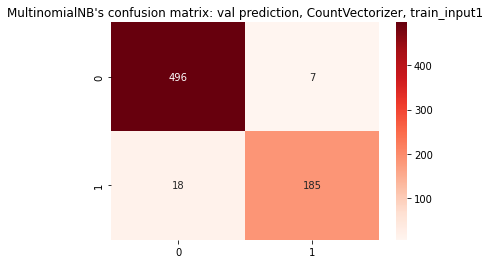

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       503
           1       0.96      0.91      0.94       203

    accuracy                           0.96       706
   macro avg       0.96      0.95      0.96       706
weighted avg       0.96      0.96      0.96       706



In [213]:
val_pred1_vect_nb, test_pred1_vect_nb = multiNB(train_vect1, train_target1, val_vect1, val_target1, test_vect1)
report(val_target1, val_pred1_vect_nb, "MultinomialNB's confusion matrix: val prediction, CountVectorizer, train_input1")

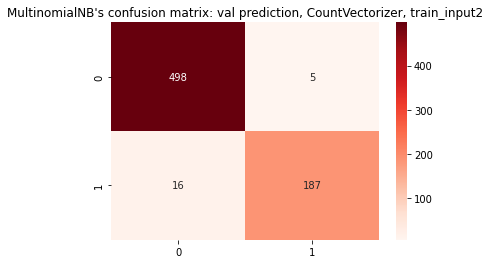

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       503
           1       0.97      0.92      0.95       203

    accuracy                           0.97       706
   macro avg       0.97      0.96      0.96       706
weighted avg       0.97      0.97      0.97       706



In [214]:
val_pred2_vect_nb, test_pred2_vect_nb = multiNB(train_vect2, train_target2, val_vect2, val_target2, test_vect2)
report(val_target2, val_pred2_vect_nb, "MultinomialNB's confusion matrix: val prediction, CountVectorizer, train_input2")

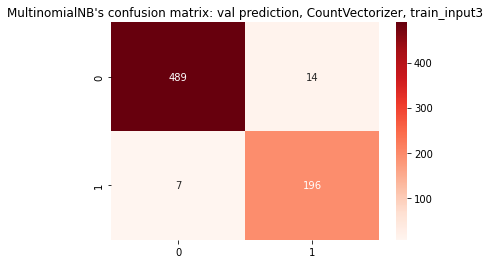

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       503
           1       0.93      0.97      0.95       203

    accuracy                           0.97       706
   macro avg       0.96      0.97      0.96       706
weighted avg       0.97      0.97      0.97       706



In [215]:
val_pred3_vect_nb, test_pred3_vect_nb = multiNB(train_vect3, train_target3, val_vect3, val_target3, test_vect3)
report(val_target3, val_pred3_vect_nb, "MultinomialNB's confusion matrix: val prediction, CountVectorizer, train_input3")

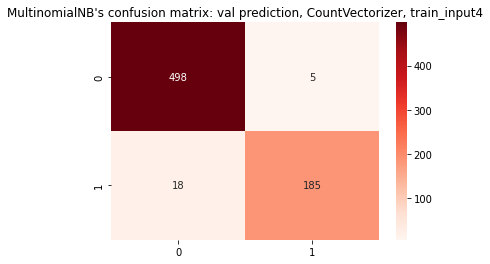

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       503
           1       0.97      0.91      0.94       203

    accuracy                           0.97       706
   macro avg       0.97      0.95      0.96       706
weighted avg       0.97      0.97      0.97       706



In [216]:
val_pred4_vect_nb, test_pred4_vect_nb = multiNB(train_vect4, train_target4, val_vect4, val_target4, test_vect4)
report(val_target4, val_pred4_vect_nb, "MultinomialNB's confusion matrix: val prediction, CountVectorizer, train_input4")

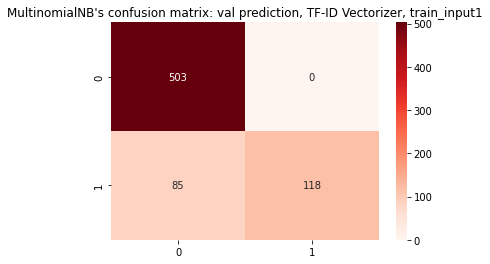

Classification Report: 
               precision    recall  f1-score   support

           0       0.86      1.00      0.92       503
           1       1.00      0.58      0.74       203

    accuracy                           0.88       706
   macro avg       0.93      0.79      0.83       706
weighted avg       0.90      0.88      0.87       706



In [217]:
val_pred1_tf_nb, test_pred1_tf_nb = multiNB(train_tf1, train_target1, val_tf1, val_target1, test_tf1)
report(val_target1, val_pred1_tf_nb, "MultinomialNB's confusion matrix: val prediction, TF-ID Vectorizer, train_input1")

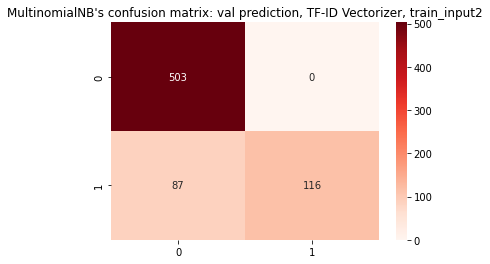

Classification Report: 
               precision    recall  f1-score   support

           0       0.85      1.00      0.92       503
           1       1.00      0.57      0.73       203

    accuracy                           0.88       706
   macro avg       0.93      0.79      0.82       706
weighted avg       0.89      0.88      0.86       706



In [218]:
val_pred2_tf_nb, test_pred2_tf_nb = multiNB(train_tf2, train_target2, val_tf2, val_target2, test_tf2)
report(val_target2, val_pred2_tf_nb, "MultinomialNB's confusion matrix: val prediction, TF-ID Vectorizer, train_input2")

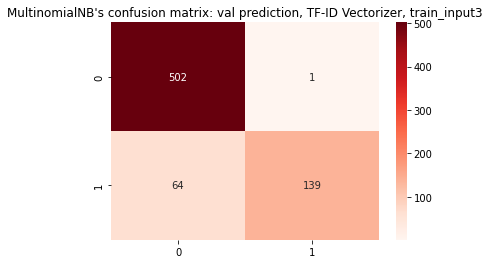

Classification Report: 
               precision    recall  f1-score   support

           0       0.89      1.00      0.94       503
           1       0.99      0.68      0.81       203

    accuracy                           0.91       706
   macro avg       0.94      0.84      0.87       706
weighted avg       0.92      0.91      0.90       706



In [219]:
val_pred3_tf_nb, test_pred3_tf_nb = multiNB(train_tf3, train_target3, val_tf3, val_target3, test_tf3)
report(val_target3, val_pred3_tf_nb, "MultinomialNB's confusion matrix: val prediction, TF-ID Vectorizer, train_input3")

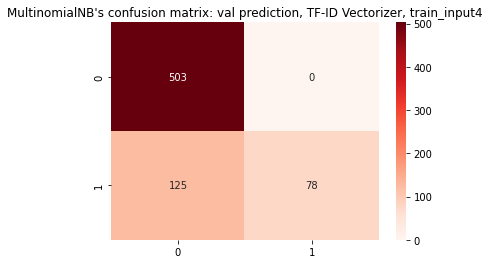

Classification Report: 
               precision    recall  f1-score   support

           0       0.80      1.00      0.89       503
           1       1.00      0.38      0.56       203

    accuracy                           0.82       706
   macro avg       0.90      0.69      0.72       706
weighted avg       0.86      0.82      0.79       706



In [220]:
val_pred4_tf_nb, test_pred4_tf_nb = multiNB(train_tf4, train_target4, val_tf4, val_target4, test_tf4)
report(val_target4, val_pred4_tf_nb, "MultinomialNB's confusion matrix: val prediction, TF-ID Vectorizer, train_input4")

> Logistic Regression

로지스틱 회귀 분류 모델을 사용한다.

나이브 베이즈와 마찬가지로 훈련이 끝난 뒤 val_input, val_target을 통해 성능 평가 지표를 보여준다.

In [221]:
def lr(train_input, train_target, val_input, val_target, test_input):
    lr = LogisticRegression()
    lr.fit(train_input, train_target)
    val_pred = lr.predict(val_input)
    test_pred = lr.predict(test_input)
    return val_pred, test_pred

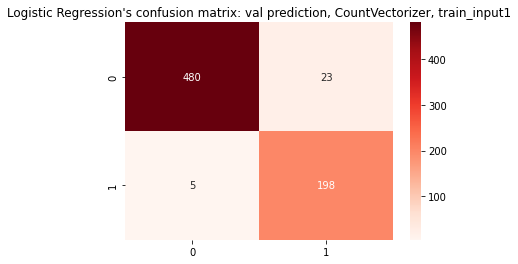

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       503
           1       0.90      0.98      0.93       203

    accuracy                           0.96       706
   macro avg       0.94      0.96      0.95       706
weighted avg       0.96      0.96      0.96       706



In [222]:
val_pred1_vect_lr, test_pred1_vect_lr = lr(train_vect1, train_target1, val_vect1, val_target1, test_vect1)
report(val_target1, val_pred1_vect_lr, "Logistic Regression's confusion matrix: val prediction, CountVectorizer, train_input1")

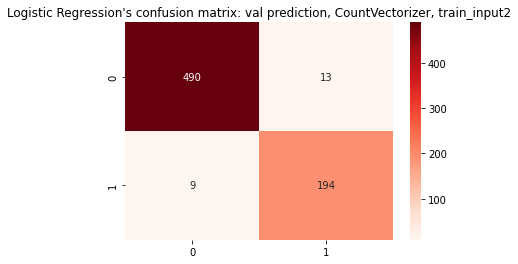

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       503
           1       0.94      0.96      0.95       203

    accuracy                           0.97       706
   macro avg       0.96      0.96      0.96       706
weighted avg       0.97      0.97      0.97       706



In [223]:
val_pred2_vect_lr, test_pred2_vect_lr = lr(train_vect2, train_target2, val_vect2, val_target2, test_vect2)
report(val_target2, val_pred2_vect_lr, "Logistic Regression's confusion matrix: val prediction, CountVectorizer, train_input2")

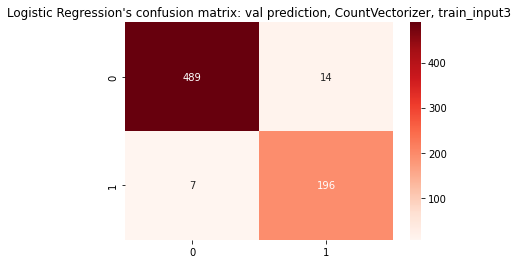

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       503
           1       0.93      0.97      0.95       203

    accuracy                           0.97       706
   macro avg       0.96      0.97      0.96       706
weighted avg       0.97      0.97      0.97       706



In [224]:
val_pred3_vect_lr, test_pred3_vect_lr = lr(train_vect3, train_target3, val_vect3, val_target3, test_vect3)
report(val_target3, val_pred3_vect_lr, "Logistic Regression's confusion matrix: val prediction, CountVectorizer, train_input3")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


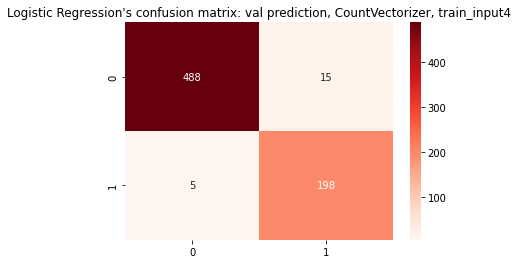

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       503
           1       0.93      0.98      0.95       203

    accuracy                           0.97       706
   macro avg       0.96      0.97      0.97       706
weighted avg       0.97      0.97      0.97       706



In [225]:
val_pred4_vect_lr, test_pred4_vect_lr = lr(train_vect4, train_target4, val_vect4, val_target4, test_vect4)
report(val_target4, val_pred4_vect_lr, "Logistic Regression's confusion matrix: val prediction, CountVectorizer, train_input4")

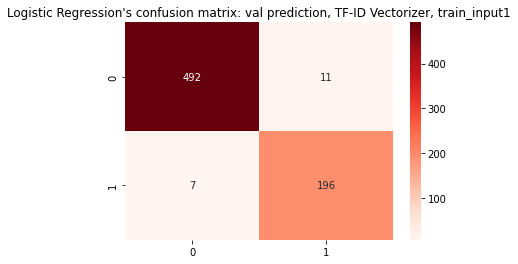

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       503
           1       0.95      0.97      0.96       203

    accuracy                           0.97       706
   macro avg       0.97      0.97      0.97       706
weighted avg       0.97      0.97      0.97       706



In [226]:
val_pred1_tf_lr, test_pred1_tf_lr = lr(train_tf1, train_target1, val_tf1, val_target1, test_tf1)
report(val_target1, val_pred1_tf_lr, "Logistic Regression's confusion matrix: val prediction, TF-ID Vectorizer, train_input1")

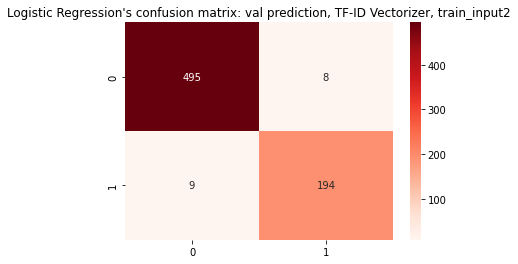

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       503
           1       0.96      0.96      0.96       203

    accuracy                           0.98       706
   macro avg       0.97      0.97      0.97       706
weighted avg       0.98      0.98      0.98       706



In [227]:
val_pred2_tf_lr, test_pred2_tf_lr = lr(train_tf2, train_target2, val_tf2, val_target2, test_tf2)
report(val_target2, val_pred2_tf_lr, "Logistic Regression's confusion matrix: val prediction, TF-ID Vectorizer, train_input2")

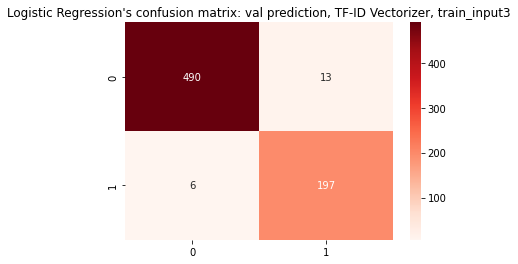

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       503
           1       0.94      0.97      0.95       203

    accuracy                           0.97       706
   macro avg       0.96      0.97      0.97       706
weighted avg       0.97      0.97      0.97       706



In [228]:
val_pred3_tf_lr, test_pred3_tf_lr = lr(train_tf3, train_target3, val_tf3, val_target3, test_tf3)
report(val_target3, val_pred3_tf_lr, "Logistic Regression's confusion matrix: val prediction, TF-ID Vectorizer, train_input3")

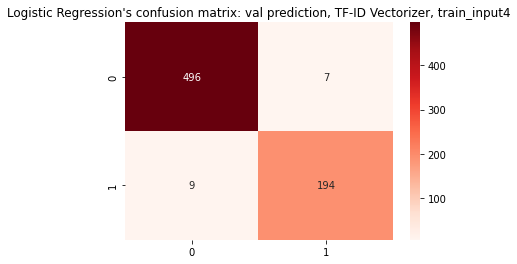

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       503
           1       0.97      0.96      0.96       203

    accuracy                           0.98       706
   macro avg       0.97      0.97      0.97       706
weighted avg       0.98      0.98      0.98       706



In [229]:
val_pred4_tf_lr, test_pred4_tf_lr = lr(train_tf4, train_target4, val_tf4, val_target4, test_tf4)
report(val_target4, val_pred4_tf_lr, "Logistic Regression's confusion matrix: val prediction, TF-ID Vectorizer, train_input4")

In [172]:
def create_model(max_words, max_length_sequence):
    
      lstm_model = Sequential()
      lstm_model.add(Embedding(max_words, 50, input_length=max_length_sequence))
      lstm_model.add(LSTM(64))
      lstm_model.add(Dropout(0.3))
      lstm_model.add(Dense(20, activation="relu"))
      lstm_model.add(Dropout(0.3))
      lstm_model.add(Dense(1, activation = "sigmoid"))
      lstm_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
      lstm_model.summary()
      return lstm_model

In [176]:
def lstm_run(lstm_model, train_padded, train_target, val_padded, val_target, test_padded):
    checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5')
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
    history = lstm_model.fit(train_padded, train_target, epochs=100, batch_size=64, validation_data=(val_padded, val_target), callbacks=[checkpoint_cb, early_stopping_cb])
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train', 'val'])
    plt.show()

    return ((lstm_model.predict(val_padded) > 0.5).astype("int32"), (lstm_model.predict(test_padded) > 0.5).astype("int32"))

> LSTM
딥러닝 모델 중 LSTM 모델을 사용한다.

relu, sigmoid 함수를 적용한 Sequential 함수로 중간 Dropout을 두 번 적용하였다.

optimizer로 adam을 사용했고, validation loss가 두 번 연속 감소하지 않을 경우 훈련을 종료한다. 

history에 저장해놓은 train_loss, val_loss를 도식화하여 표현한다.

마찬가지로 LSTM 모델이 예측한 val_pred와 val_target을 비교해 성능을 평가한다.
 
이때 predict_class가 존재하지 않으므로 0.5를 기준으로 라벨링하였다.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1472, 50)          2114900   
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                1300      
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,145,661
Trainable params: 2,145,661
No

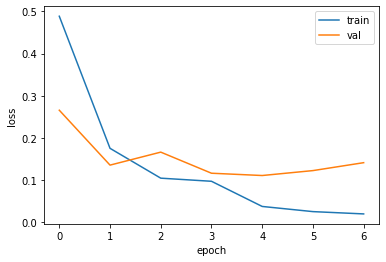

In [177]:
lstm_model1 = create_model(word_index1, max_length_sequence1)
val_pred1_lstm, test_pred1_lstm = lstm_run(lstm_model1, train_pad1, train_target1, val_pad1, val_target1, test_pad1)

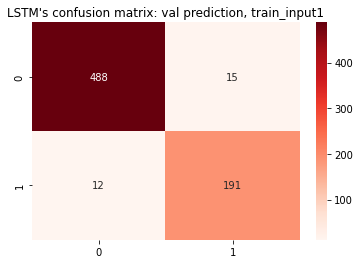

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       503
           1       0.93      0.94      0.93       203

    accuracy                           0.96       706
   macro avg       0.95      0.96      0.95       706
weighted avg       0.96      0.96      0.96       706



In [230]:
report(val_target1, val_pred1_lstm, "LSTM's confusion matrix: val prediction, train_input1")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1474, 50)          2124050   
                                                                 
 lstm_2 (LSTM)               (None, 64)                29440     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 20)                1300      
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,154,811
Trainable params: 2,154,811
No

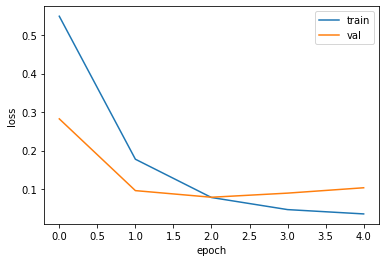

In [179]:
lstm_model2 = create_model(word_index2, max_length_sequence2)
val_pred2_lstm, test_pred2_lstm = lstm_run(lstm_model2, train_pad2, train_target2, val_pad2, val_target2, test_pad2)

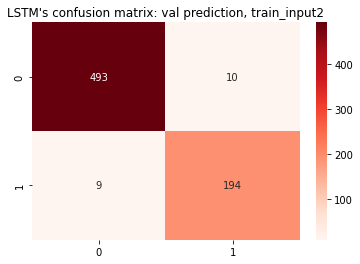

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       503
           1       0.95      0.96      0.95       203

    accuracy                           0.97       706
   macro avg       0.97      0.97      0.97       706
weighted avg       0.97      0.97      0.97       706



In [231]:
report(val_target2, val_pred2_lstm, "LSTM's confusion matrix: val prediction, train_input2")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 2018, 50)          1607150   
                                                                 
 lstm_3 (LSTM)               (None, 64)                29440     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                1300      
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,637,911
Trainable params: 1,637,911
No

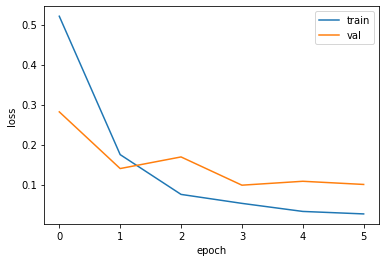

In [181]:
lstm_model3 = create_model(word_index3, max_length_sequence3)
val_pred3_lstm, test_pred3_lstm = lstm_run(lstm_model3, train_pad3, train_target3, val_pad3, val_target3, test_pad3)

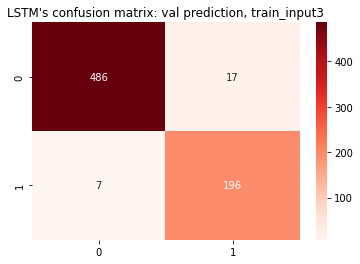

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       503
           1       0.92      0.97      0.94       203

    accuracy                           0.97       706
   macro avg       0.95      0.97      0.96       706
weighted avg       0.97      0.97      0.97       706



In [232]:
report(val_target3, val_pred3_lstm, "LSTM's confusion matrix: val prediction, train_input3")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1708, 50)          2113200   
                                                                 
 lstm_4 (LSTM)               (None, 64)                29440     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 20)                1300      
                                                                 
 dropout_9 (Dropout)         (None, 20)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,143,961
Trainable params: 2,143,961
No

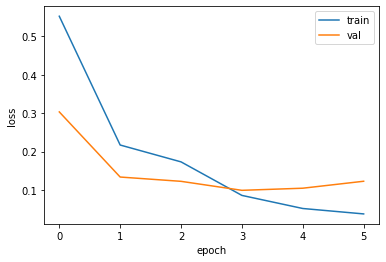

In [183]:
lstm_model4 = create_model(word_index4, max_length_sequence4)
val_pred4_lstm, test_pred4_lstm = lstm_run(lstm_model4, train_pad4, train_target4, val_pad4, val_target4, test_pad4)

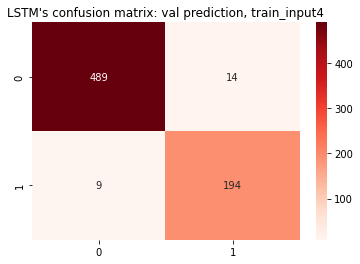

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       503
           1       0.93      0.96      0.94       203

    accuracy                           0.97       706
   macro avg       0.96      0.96      0.96       706
weighted avg       0.97      0.97      0.97       706



In [233]:
report(val_target4, val_pred4_lstm, "LSTM's confusion matrix: val prediction, train_input4")

# 4. 스팸 필터링 모델

> 모델 선정: 나이브 베이즈 및 LSTM

1). ML: CountVectorizer, TF-ID Vectorizer에 기반한 MultinomialNB, LogistricRegrssion 2). DL: Tokenizer-Padding을 통한 LSTM의 성능 평가를 통해, 필터링할 조건을 고른다.

TF-ID Vectorizer에 기반한 MultinomialNB가 일반 메일로 분류했다면 넘어가고, 스팸으로 분류했다면 이차적으로 LSTM 모델을 통해 다시 한 번 검사한다. 

이때 고려해야 할 조건은 전처리한 데이터의 종류, ML의 종류, ML이 택하는 벡터화 기법의 종류 등이 존재한다.



In [200]:
nb_lstm_pred = np.array([])

for i in range(len(test_pred4_tf_nb)):
    if test_pred4_tf_nb[i] == 0:
        nb_lstm_pred = np.append(nb_lstm_pred, 0)
    else:
        nb_lstm_pred = np.append(nb_lstm_pred, test_pred4_lstm[i])

네 번째 전처리 데이터(단어 정규화, 소문자화, 특수문자 및 숫자 제외)를 사용하였다. 즉 불용어를 걸러내지 않은 데이터이다.

이 데이터를 TF-ID Vectorizer를 통해 가중치에 따라 벡터화하고, 나이브 베이즈 multinomialNB를 통해 1차 라벨링을 검사한다. 만일 나이브 베이즈가 정상 메일이라 간주한다면 정상 메일로 간주한다. 스팸 메일로 간주한 경우 LSTM 모델이 2차 라벨링을 검사한다.

> 테스트 예측

모델 선정 이후 test_input4를 예측한 값을 csv 파일로 저장한다.

In [201]:
result = pd.concat([test_set['id'], pd.DataFrame(nb_lstm_pred).astype(int)], axis=1, ignore_index=True)

In [234]:
result = result.rename(columns={0:'id', 1:'label'})

In [235]:
result.to_csv('result_data.csv', index=False)